In [110]:
from pathlib import Path
import polars as pl
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import notebook

In [4]:
%%time
base_path = Path()
file_path = base_path / 'data_aws'
parquet_files = list(file_path.glob('*.parquet'))

CPU times: total: 15.6 ms
Wall time: 616 ms


In [5]:
#getting the list of tickers
tickers = []
with open(base_path / 'tickers.txt', 'r') as f:
    tickers.extend(line.strip().split('/')[0][1:].replace(",", "") for line in f)

print('No duplicates in tickers') if len(tickers) == len(list(set(tickers))) else 'Duplicates in tickers'

No duplicates in tickers


In [6]:
GRANULARITIES = ["2h", "4h", '6h', "12h", "1d"]

In [7]:
parquets = [file for file in parquet_files if GRANULARITIES[-1] in file.name]

In [8]:
lazy_frames = {file.name.split('_')[0]: pl.scan_parquet(file)
               for file in parquets if file.name.split('_')[0] in tickers}

In [11]:
datas = pl.collect_all(list(lazy_frames.values()))
results = dict(zip(lazy_frames.keys(), datas))

## Prix close

In [165]:
Xs = {key:pl.DataFrame({'date': results[key]['date'], 'scaled_price':scaled_prices[key]}) 
      for key in notebook.tqdm(scaled_prices.keys())}

In [164]:
scaler = MinMaxScaler()
scaled_prices = {key: np.ravel(scaler.fit_transform(results[key]['close'].to_numpy().reshape(-1, 1))) 
                 for key in notebook.tqdm(results.keys())}

  0%|          | 0/120 [00:00<?, ?it/s]

In [166]:
dfs = {key: {f"moment_{i}":stats.moment(scaled_prices[key], moment = i) for i in range(1, 11)} for key in scaled_prices.keys()}

In [167]:
dfs['BTC']

{'moment_1': 0.0,
 'moment_2': 0.06269259100001444,
 'moment_3': 0.007417053706144146,
 'moment_4': 0.008942608849710073,
 'moment_5': 0.0026196691863855587,
 'moment_6': 0.0018539280328004253,
 'moment_7': 0.000797982125671483,
 'moment_8': 0.00047647098514977827,
 'moment_9': 0.00024147518921875102,
 'moment_10': 0.00013788714572725365}

In [169]:
X = pd.DataFrame(dfs).T
X

,moment_1,moment_2,moment_3,moment_4,moment_5,moment_6,moment_7,moment_8,moment_9,moment_10
1000BONK,0.0,0.049172,0.002442,0.005415,0.000689,0.000923,0.000219,0.000203,0.000072,0.000053
1000FLOKI,0.0,0.058116,0.025564,0.016422,0.010315,0.006851,0.004687,0.003296,0.002369,0.001735
1000LUNC,0.0,0.027674,0.006352,0.004295,0.002359,0.001583,0.001103,0.000809,0.000609,0.000466
1000PEPE,0.0,0.069570,0.030386,0.019687,0.011892,0.007528,0.004837,0.003173,0.002119,0.001439
1000RATS,0.0,0.038215,0.001530,0.004548,0.000798,0.000855,0.000323,0.000239,0.000127,0.000084
...,...,...,...,...,...,...,...,...,...,...
XAI,0.0,0.081593,0.006274,0.011476,0.002181,0.002081,0.000613,0.000441,0.000165,0.000103
XLM,0.0,0.030384,0.008659,0.004972,0.002717,0.001669,0.001068,0.000708,0.000481,0.000334
XRP,0.0,0.028791,0.006130,0.003921,0.001847,0.001083,0.000639,0.000400,0.000257,0.000170
ZETA,0.0,0.078191,-0.002101,0.010399,-0.000244,0.001638,0.000012,0.000288,0.000017,0.000056


In [171]:
X = X.drop(columns=['moment_1'],axis=1)

Text(0.5, 0, 'n_components')

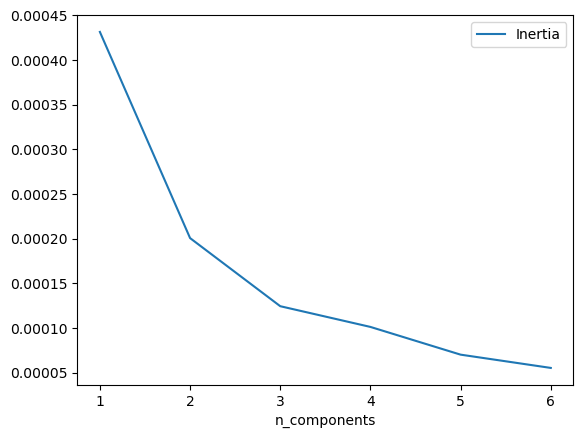

In [172]:
n_clusters = np.arange(1, 7)
models = [TimeSeriesKMeans(n, metric="euclidean").fit(X) for n in n_clusters]

plt.plot(n_clusters, [m.inertia_ for m in models], label='Inertia')

plt.legend(loc='best')
plt.xlabel('n_components')

l'inertie représente la somme des distances au carré des points de données à leur centre de cluster le plus proche. L'inertie mesure à quel point les points de chaque cluster sont proches de leur centroïde respectif. Un faible score d'inertie signifie que les points sont bien regroupés autour de leurs centroïdes, ce qui est généralement un signe de bons clusters

In [173]:
N_CLUSTERS = 3
models = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="euclidean", max_iter=50, random_state=42) #params à optimiser
labels = models.fit_predict(X)

In [174]:
labels

array([2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0,
       0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2, 2, 0, 2, 1, 2, 2, 1, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 2, 0, 1,
       2, 1, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 1, 2, 2, 1,
       2, 0, 2, 1, 2, 1, 0, 0, 1, 0], dtype=int64)

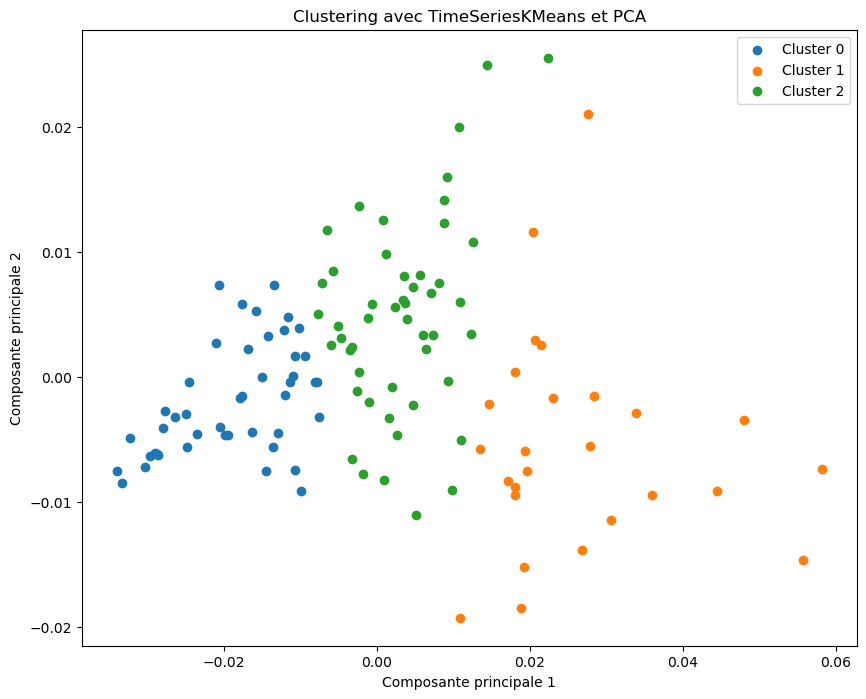

In [175]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot des clusters
plt.figure(figsize=(10, 8))
for i in range(N_CLUSTERS):
    plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], label=f'Cluster {i}')
plt.title("Clustering avec TimeSeriesKMeans et PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.show()

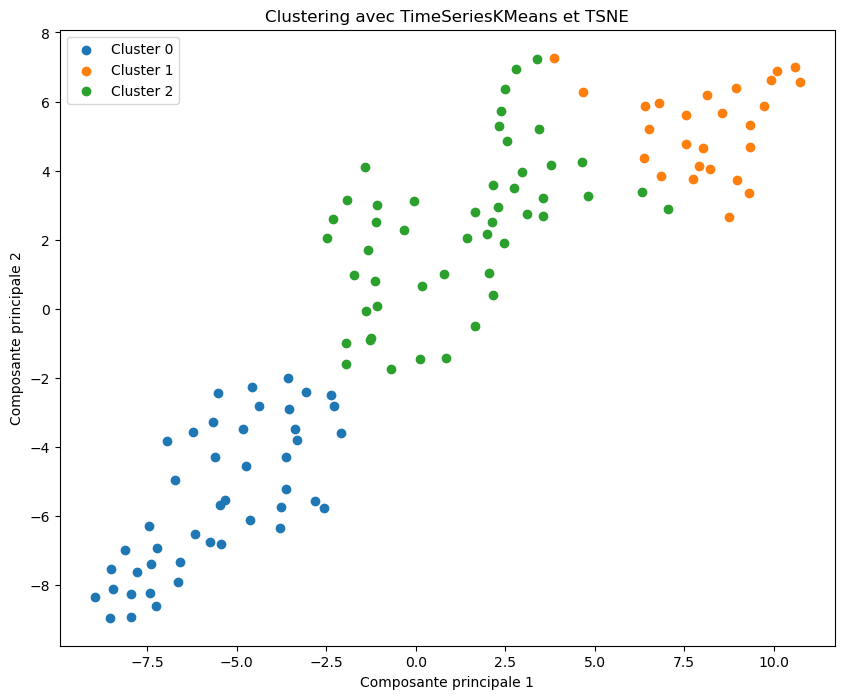

In [177]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_reduced = tsne.fit_transform(X)

# Plot des clusters
plt.figure(figsize=(10, 8))
for i in range(N_CLUSTERS):
    plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], label=f'Cluster {i}')
plt.title("Clustering avec TimeSeriesKMeans et TSNE")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.show()